In [ ]:
import pandas as pd
from datetime import datetime

# Lecture du premier fichier Excel
chemin_excel_1 = '/content/courbedeprix.xlsx'
df_prix = pd.read_excel(chemin_excel_1, header=None)

# Renommer les colonnes comme Date, Heure et Prix respectivement
df_prix.columns = ['Date', 'Heure', 'Prix']


# Conversion de l'heure en chaînes de caractères
df_prix['Heure'] = pd.to_timedelta(df_prix['Heure'], unit='h')



# Fusionner les colonnes de date et d'heure pour former un index datetime
df_prix['Datetime'] = pd.to_datetime(df_prix['Date']) + df_prix['Heure']
df_prix.set_index('Datetime', inplace=True)
# Supprimer les colonnes de date et d'heure maintenant que nous avons l'index
df_prix.drop(columns=['Date', 'Heure'], inplace=True)

# Afficher les premières lignes pour vérification
print("DataFrame pour les prix :")




DataFrame pour les prix :


In [ ]:



# Lecture du deuxième fichier Excel (trois feuilles de calcul)
chemin_excel_2 = '/content/PEGC 2025.xlsx'
df_achat = pd.read_excel(chemin_excel_2, sheet_name='Puissances Achat')
df_vente = pd.read_excel(chemin_excel_2, sheet_name='Puissance Vente')
df_total = pd.read_excel(chemin_excel_2, sheet_name='Total')






print("\nDataFrame pour Total :")

print(df_total.shape[0])



DataFrame pour Total :
8761


In [ ]:
# Filtrer les valeurs incorrectes dans la colonne "Total" en utilisant une expression régulière
df_total['Datetime'] = df_total['Total'].str.extract(r'(\d{2}\.\d{2}\. \d{2}:\d{2})', expand=False)

# Convertir la colonne "Datetime" en format datetime
df_total['Datetime'] = pd.to_datetime(df_total['Datetime'], format='%d.%m. %H:%M', errors='coerce')

# Remplacer les années 1900 par l'année 2025
df_total['Datetime'] = df_total['Datetime'].mask(df_total['Datetime'].dt.year == 1900, df_total['Datetime'] + pd.DateOffset(years=2025-1900))

# Suppression des valeurs incorrectes maintenant que nous avons la colonne de datetime
df_total.drop(columns=['Total'], inplace=True)

# Supprimer les lignes avec des valeurs NaN dans la colonne de datetime
df = df_total.dropna(subset=['Datetime'])

# Réorganiser les colonnes pour mettre la colonne "Datetime" en première position
cols = list(df.columns)
cols.remove('Datetime')
cols.insert(0, 'Datetime')
df_total = df_total[cols]

print(df_total.shape[0])

8761


In [ ]:
# Supprimer la première colonne (correspondant aux dates) et la première ligne (correspondant aux titres)
df_achat_sans= df_achat.iloc[:, 1:]



# Calculer la somme des valeurs pour chaque ligne de la feuille de calcul "ventes" (sauf la première colonne et la première ligne)
somme_achat = df_achat_sans.sum(axis=1)

print(somme_achat.shape[0])
# Ajouter une colonne "vente Mwh" à la DataFrame total avec les valeurs de somme
df_total['Achat Mwh'] = somme_achat
print(df_total.shape[0])
# Afficher les premières lignes de la DataFrame pour vérification



8761
8761


In [ ]:


def handle_dst(df):
    # Supprimer les heures 03:00 du matin qui suivent le changement d'heure de mars
    df = df[~((df['Datetime'].dt.month == 3) & (df['Datetime'].dt.day == 30) & (df['Datetime'].dt.hour == 3))]

    # Dupliquer les heures 02:00 du matin pendant le changement d'heure d'octobre
    df_october = df[(df['Datetime'].dt.month == 10) & (df['Datetime'].dt.day == 26) & (df['Datetime'].dt.hour == 2)]
    df_duplicated = df_october.copy()
    df_duplicated['Datetime'] += pd.Timedelta(hours=1)

    # Obtenir l'indice de la ligne originale
    idx = df.index[df['Datetime'] == pd.Timestamp('2025-10-26 02:00:00')][0]

    # Insérer la ligne dupliquée à la même position que la ligne originale
    df = pd.concat([df.iloc[:idx+1], df_duplicated, df.iloc[idx+1:]], ignore_index=True)

    return df

def handle_dst_s(series):
    # Supprimer les heures 03:00 du matin qui suivent le changement d'heure de mars
    series = series[~((series.index.month == 3) & (series.index.day == 30) & (series.index.hour == 3))]

    # Dupliquer les heures 02:00 du matin pendant le changement d'heure d'octobre
    october_series = series[(series.index.month == 10) & (series.index.day == 26) & (series.index.hour == 2)]
    duplicated_series = october_series.copy()
    duplicated_series.index += pd.Timedelta(hours=1)

    # Obtenir l'indice de la ligne originale
    idx = series.index.get_loc(pd.Timestamp('2025-10-26 02:00:00'))

    # Insérer la ligne dupliquée à la même position que la ligne originale
    series = pd.concat([series.iloc[:idx+1], duplicated_series, series.iloc[idx+1:]])

    return series



df_total = handle_dst(df_total)
print(df_total.head(-5))
print(df_total.shape[0])

                Datetime  Somme achats planifiés  [MWh]  \
0    2025-01-01 01:00:00                           86.8   
1    2025-01-01 02:00:00                           86.8   
2    2025-01-01 03:00:00                           86.9   
3    2025-01-01 04:00:00                           86.8   
4    2025-01-01 05:00:00                           86.8   
...                  ...                            ...   
8751 2025-12-31 15:00:00                           87.6   
8752 2025-12-31 16:00:00                           87.6   
8753 2025-12-31 17:00:00                           87.6   
8754 2025-12-31 18:00:00                           87.5   
8755 2025-12-31 19:00:00                           87.6   

      Somme achats confirmés  [MWh]  Somme ventes planifiées  [MWh]  \
0                                60                               0   
1                                60                               0   
2                                60                               0   
3      

In [ ]:
# Extraction des données pour l'année 2025
df_prix_2025 = df_prix.loc[df_prix.index.year == 2025]


# Suppression de la première ligne
df_prix_2025 = df_prix_2025.iloc[1:]
df_prix_2025 = handle_dst_s(df_prix_2025)

# Afficher les premières lignes de la DataFrame pour vérification
print("\nDataFrame des prix pour l'année 2025 :")

print(df_prix_2025.shape[0])
print(df_prix_2025.head(-1))


DataFrame des prix pour l'année 2025 :
8759
                       Prix
Datetime                   
2025-01-01 01:00:00   90.86
2025-01-01 02:00:00   81.50
2025-01-01 03:00:00   76.62
2025-01-01 04:00:00   70.35
2025-01-01 05:00:00   68.86
...                     ...
2025-12-31 18:00:00  128.59
2025-12-31 19:00:00  137.85
2025-12-31 20:00:00  140.85
2025-12-31 21:00:00  120.92
2025-12-31 22:00:00  112.45

[8758 rows x 1 columns]


In [ ]:
# Colonnes à conserver
colonnes_conservees = ['Achat Mwh', 'Somme ventes confirmées  [MWh]', 'Verbrauch  [MWh]', 'Somme Short  [MWh]','Somme Long  [MWh]']
df_total.set_index('Datetime', inplace=True)
# Fusion des DataFrames en utilisant l'index comme clé de fusion
df_fusion = df_prix_2025.merge(df_total[colonnes_conservees], how='left', left_index=True, right_index=True)

# Afficher les premières lignes du DataFrame fusionné pour vérification
print("\nDataFrame fusionné des prix pour l'année 2025 avec Total (colonnes conservées) :")
print(df_fusion.head(-1))



DataFrame fusionné des prix pour l'année 2025 avec Total (colonnes conservées) :
                       Prix  Achat Mwh  Somme ventes confirmées  [MWh]  \
Datetime                                                                 
2025-01-01 01:00:00   90.86      146.8                               1   
2025-01-01 02:00:00   81.50      146.8                               1   
2025-01-01 03:00:00   76.62      146.9                               1   
2025-01-01 04:00:00   70.35      146.8                               1   
2025-01-01 05:00:00   68.86      146.8                               1   
...                     ...        ...                             ...   
2025-12-31 18:00:00  128.59      205.5                               1   
2025-12-31 19:00:00  137.85      205.6                               1   
2025-12-31 20:00:00  140.85      205.6                               1   
2025-12-31 21:00:00  120.92      144.5                               1   
2025-12-31 22:00:00  112.45   

In [ ]:
# Filtrer les heures de pointe et les heures creuses dans le DataFrame fusionné
# Les heures de pointe sont les jours de la semaine entre 8h et 20h
df_peakload = df_fusion[(df_fusion.index.hour >= 9) & (df_fusion.index.hour < 21) & (df_fusion.index.weekday < 5)].copy()


# Les heures creuses sont les heures en dehors de cette plage horaire
#df_offpeak = df_fusion[~df_peakload]
df_offpeak = df_fusion[~((df_fusion.index.hour >= 9) & (df_fusion.index.hour < 21) & (df_fusion.index.weekday < 5))].copy()

# Afficher les premières lignes des DataFrames pour vérification
print("\nDataFrame pour les heures de pointe (peakload) :")
print(df_peakload.head())

print("\nDataFrame pour les heures creuses (offpeak) :")
print(df_offpeak.head())


DataFrame pour les heures de pointe (peakload) :
                       Prix  Achat Mwh  Somme ventes confirmées  [MWh]  \
Datetime                                                                 
2025-01-01 09:00:00  101.35      207.9                               1   
2025-01-01 10:00:00  107.54      207.9                               1   
2025-01-01 11:00:00  108.65      207.9                               1   
2025-01-01 12:00:00  108.00      207.8                               1   
2025-01-01 13:00:00  109.61      207.9                               1   

                     Verbrauch  [MWh]  Somme Short  [MWh]  Somme Long  [MWh]  
Datetime                                                                      
2025-01-01 09:00:00             132.2                 0.0               74.7  
2025-01-01 10:00:00             136.3                 0.0               70.6  
2025-01-01 11:00:00             138.8                 0.0               68.1  
2025-01-01 12:00:00             138.

In [ ]:
# Calculer la valeur pour chaque heure

#df_peakload['OP MWh'] = (df_peakload['Achat Mwh'] - df_peakload['Somme ventes confirmées  [MWh]'] - df_peakload['Verbrauch  [MWh]']) #* df_peakload['Prix']
#df_offpeak['OP MWh'] = (df_offpeak['Achat Mwh'] - df_offpeak['Somme ventes confirmées  [MWh]'] - df_offpeak['Verbrauch  [MWh]']) #* df_offpeak['Prix']
df_peakload['OP MWh'] = (df_peakload['Achat Mwh'] - df_peakload['Somme ventes confirmées  [MWh]']- df_peakload['Verbrauch  [MWh]']) #* df_peakload['Prix']
df_offpeak['OP MWh'] = (df_offpeak['Achat Mwh'] - df_offpeak['Somme ventes confirmées  [MWh]']- df_offpeak['Verbrauch  [MWh]']) #* df_offpeak['Prix']

In [ ]:
# Filtrer toutes les heures de l'année entière
df_baseload = df_fusion.copy()

# Calculer la valeur pour chaque heure en baseload
df_baseload['OP MWh'] = (df_baseload['Achat Mwh'] - df_baseload['Somme ventes confirmées  [MWh]']- df_baseload['Verbrauch  [MWh]']) #* df_baseload['Prix']

# Afficher les premières lignes du DataFrame baseload pour vérification
print("\nDataFrame pour les heures de baseload (année entière) :")
print(df_baseload.head())
print(df_offpeak["Somme Long  [MWh]"].sum()-df_offpeak["Somme Short  [MWh]"].sum())



DataFrame pour les heures de baseload (année entière) :
                      Prix  Achat Mwh  Somme ventes confirmées  [MWh]  \
Datetime                                                                
2025-01-01 01:00:00  90.86      146.8                               1   
2025-01-01 02:00:00  81.50      146.8                               1   
2025-01-01 03:00:00  76.62      146.9                               1   
2025-01-01 04:00:00  70.35      146.8                               1   
2025-01-01 05:00:00  68.86      146.8                               1   

                     Verbrauch  [MWh]  Somme Short  [MWh]  Somme Long  [MWh]  \
Datetime                                                                       
2025-01-01 01:00:00             110.0                 0.0               35.8   
2025-01-01 02:00:00             108.2                 0.0               37.6   
2025-01-01 03:00:00             107.7                 0.0               38.2   
2025-01-01 04:00:00            

[-83358.1, 1144.7999999999647, -82213.30000000005]


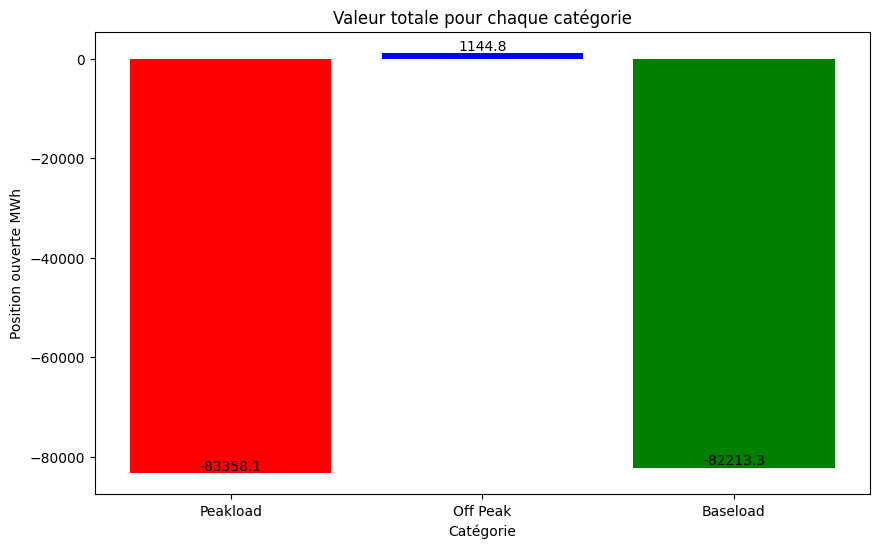

In [ ]:
import matplotlib.pyplot as plt

# Calculer la valeur totale pour peakload, off peak et baseload

total_offpeak_Mwh = df_offpeak['OP MWh'].sum() #/5628
total_peakload_Mwh = df_peakload['OP MWh'].sum()#/3132-total_offpeak
total_baseload_Mwh = df_baseload['OP MWh'].sum()#/8760-total_peakload

# Créer un histogramme représentant la valeur totale pour chaque catégorie
categories = ['Peakload', 'Off Peak', 'Baseload']
valeurs = [total_peakload_Mwh, total_offpeak_Mwh, total_baseload_Mwh]
print(valeurs)

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, valeurs, color=['red', 'blue', 'green'])
plt.xlabel('Catégorie')
plt.ylabel('Position ouverte MWh')
plt.title('Valeur totale pour chaque catégorie')

# Ajouter les valeurs exactes au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()


In [ ]:
# Calculer la valeur pour chaque heure

df_peakload['OP EUR'] = (df_peakload['Achat Mwh'] - df_peakload['Somme ventes confirmées  [MWh]'] - df_peakload['Verbrauch  [MWh]']) * df_peakload['Prix']
df_offpeak['OP EUR'] = (df_offpeak['Achat Mwh'] - df_offpeak['Somme ventes confirmées  [MWh]'] - df_offpeak['Verbrauch  [MWh]']) * df_offpeak['Prix']
print(df_peakload['OP EUR'].head(-10))
# Filtrer toutes les heures de l'année entière
df_baseload = df_fusion.copy()

# Calculer la valeur pour chaque heure en baseload
df_baseload['OP EUR'] = (df_baseload['Achat Mwh'] - df_baseload['Somme ventes confirmées  [MWh]'] - df_baseload['Verbrauch  [MWh]']) * df_baseload['Prix']

# Afficher les premières lignes du DataFrame baseload pour vérification
print("\nDataFrame pour les heures de baseload (année entière) :")
#print(df_baseload.head())

Datetime
2025-01-01 09:00:00    7570.845
2025-01-01 10:00:00    7592.324
2025-01-01 11:00:00    7399.065
2025-01-01 12:00:00    7365.600
2025-01-01 13:00:00    7661.739
                         ...   
2025-12-30 18:00:00    4573.737
2025-12-30 19:00:00    5565.476
2025-12-30 20:00:00    6933.834
2025-12-31 09:00:00    4832.760
2025-12-31 10:00:00    3438.342
Name: OP EUR, Length: 3122, dtype: float64

DataFrame pour les heures de baseload (année entière) :


[-8227880.120000001, -1839901.5990000027, -10067781.719000004]


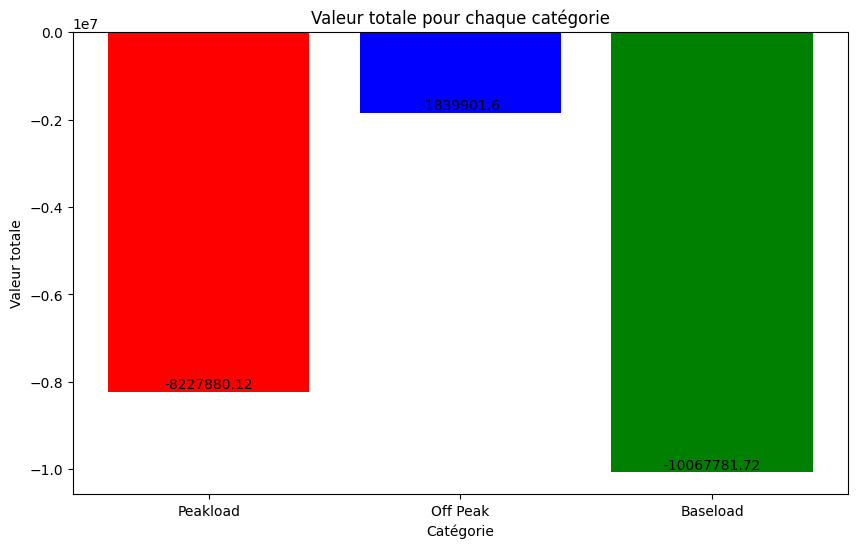

In [ ]:
# Calculer la valeur totale pour peakload, off peak et baseload

total_offpeak_EUR = df_offpeak['OP EUR'].sum()#/df_offpeak['Prix'].sum()
total_peakload_EUR = df_peakload['OP EUR'].sum()#/df_offpeak['Prix'].sum()-total_baseload
total_baseload_EUR = df_baseload['OP EUR'].sum()#/8760- total_peakload

# Créer un histogramme représentant la valeur totale pour chaque catégorie
categories = ['Peakload', 'Off Peak', 'Baseload']
valeurs = [total_peakload_EUR, total_offpeak_EUR, total_baseload_EUR]
print(valeurs)

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, valeurs, color=['red', 'blue', 'green'])
plt.xlabel('Catégorie')
plt.ylabel('Valeur totale')
plt.title('Valeur totale pour chaque catégorie')

# Ajouter les valeurs exactes au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()

[-26.614974457215837, 0.20341151385926878, -9.385079908675804]


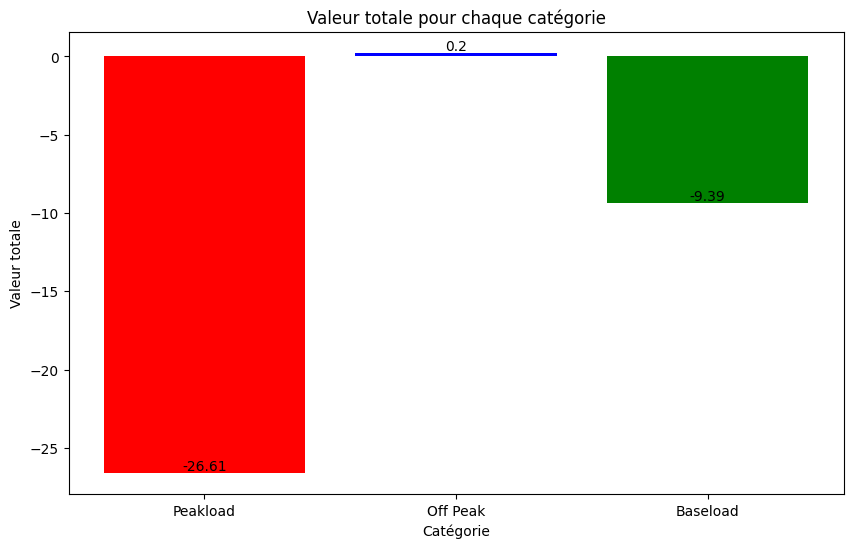

In [ ]:
total_offpeak_MW=total_offpeak_Mwh/5628
total_peakload_MW=total_peakload_Mwh/3132
total_baseload_MW=total_baseload_Mwh/8760

# Créer un histogramme représentant la valeur totale pour chaque catégorie
categories = ['Peakload', 'Off Peak', 'Baseload']
valeurs = [total_peakload_MW, total_offpeak_MW, total_baseload_MW]
print(valeurs)

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, valeurs, color=['red', 'blue', 'green'])
plt.xlabel('Catégorie')
plt.ylabel('Valeur totale')
plt.title('Valeur totale pour chaque catégorie')

# Ajouter les valeurs exactes au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()

[-30.906426500550847, -4.6054317531881805, -15.123126446951087]


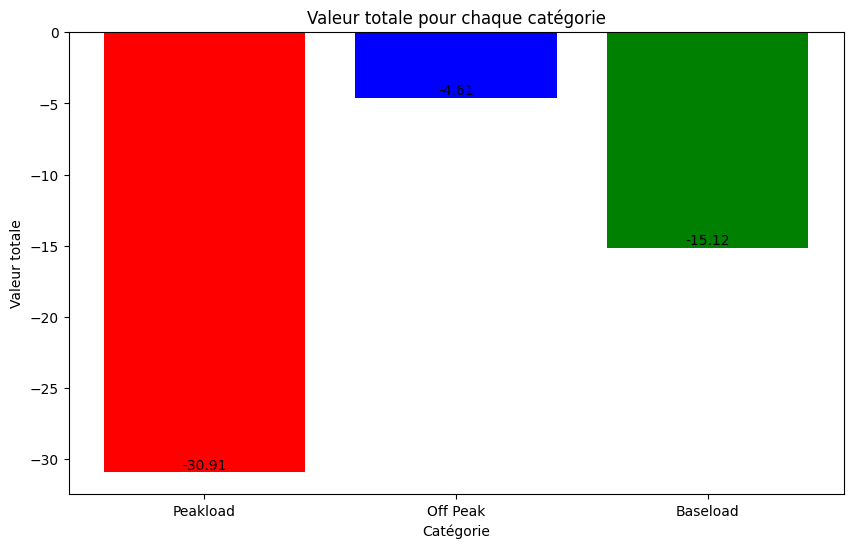

In [ ]:
prix_peakload_moy=df_peakload['Prix'].mean()
prix_offpeak_moy=df_offpeak['Prix'].mean()
prix_baseload_moy=df_baseload['Prix'].mean()

total_baseload_VH=total_baseload_EUR/(prix_baseload_moy*8760)
total_offpeak_VH=total_offpeak_EUR/(prix_offpeak_moy*5628)
total_peakload_VH=total_peakload_EUR/(prix_peakload_moy*3132)


# Créer un histogramme représentant la valeur totale pour chaque catégorie
categories = ['Peakload', 'Off Peak', 'Baseload']
valeurs = [total_peakload_VH, total_offpeak_VH, total_baseload_VH]
print(valeurs)

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, valeurs, color=['red', 'blue', 'green'])
plt.xlabel('Catégorie')
plt.ylabel('Valeur totale')
plt.title('Valeur totale pour chaque catégorie')

# Ajouter les valeurs exactes au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()